In [1]:
# Add description here
#
# *Note:* You can open this file as a notebook (JupyterLab: right-click on it in the side bar -> Open With -> Notebook)

In [2]:
# Uncomment the next two lines to enable auto reloading for imported modules
# %load_ext autoreload
# %autoreload 2
# For more info, see:
# https://docs.ploomber.io/en/latest/user-guide/faq_index.html#auto-reloading-code-in-jupyter

In [3]:
# If this task has dependencies, declare them in the YAML spec and leave this
# as None
from datetime import timedelta
from pathlib import Path

import numpy as np
from darts.utils.statistics import plot_hist

from darts.metrics import rmse, mape

from darts.utils.timeseries_generation import datetime_attribute_timeseries
from matplotlib import pyplot as plt
from numpy import mean
from pandas import DatetimeIndex
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import darts.timeseries
import pandas as pd
import torch
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, InvertibleMapper
from darts.models import TCNModel
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit

from hydro_timeseries.darts_utils import backtest_minute_data, to_daily, to_hourly, ffill_to_minute, to_timestep
from hydro_timeseries.pytorch_utils import RMSELoss, MSELoss, MAELoss, pl_trainer_kwargs
from hydro_timeseries.util import load_timeseries_csv, add_mean_vars
from hydro_timeseries.variables import Variables
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

upstream = None

# This is a placeholder, leave it as None
product = None

In [4]:
# Parameters
random_seed = 1
valid_from = "2021-10-01"
simulate_from = "2021-12-01"
plots_path = "/home/m/repo/hydro-power-prediction/plots"
upstream = {"run-tests": {"nb": "/home/m/repo/hydro-power-prediction/reports/run_tests.ipynb", "data": "/home/m/repo/hydro-power-prediction/products/data/data_raw_tested.csv"}}
product = {"nb": "/home/m/repo/hydro-power-prediction/reports/exploratory_darts_cnn.ipynb"}


In [5]:

data = load_timeseries_csv(upstream['run-tests']['data'])
data = add_mean_vars(data)
data = data.dropna(axis = 0)
data_hourly = data.resample('h').mean()

simulate_from = pd.to_datetime(simulate_from)
valid_from = pd.to_datetime(valid_from)

train_until = valid_from - timedelta(hours=1)
plots_path = Path(plots_path)

In [6]:
data_ts = TimeSeries.from_dataframe(data)

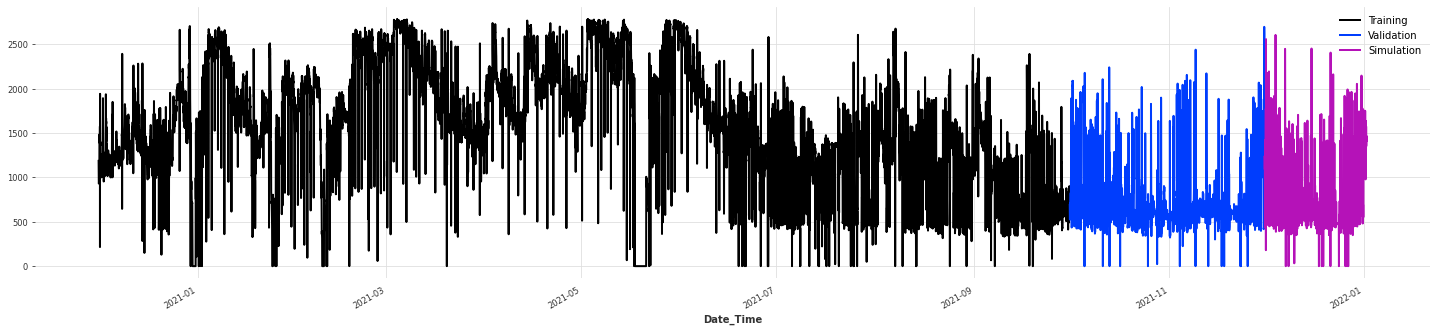

In [7]:
'''
The serious splits
'''
plt.figure(100, figsize=(25, 5))
data_ts[:valid_from]['Value'].plot(label="Training")
data_ts[valid_from:simulate_from]['Value'].plot(label="Validation")
data_ts[simulate_from:]['Value'].plot(label="Simulation")
plt.show()

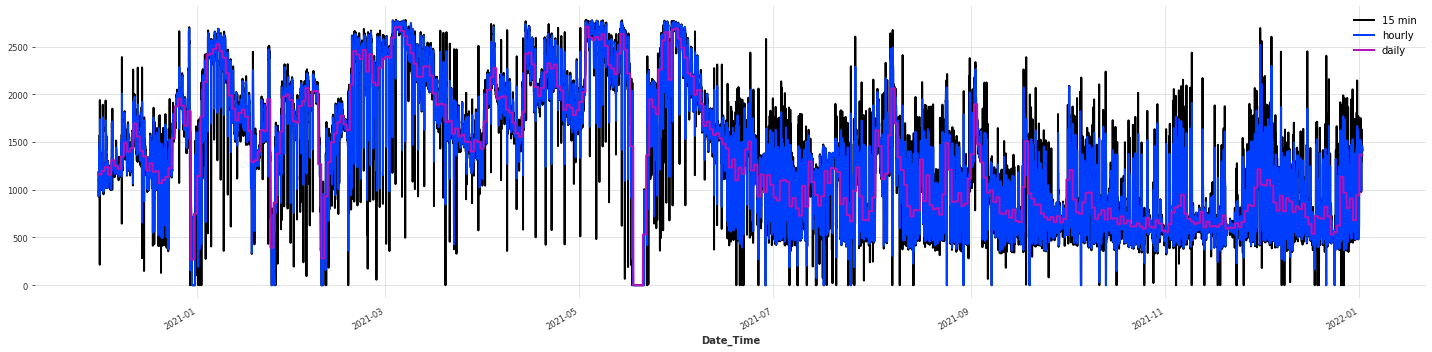

In [8]:
'''
Transforming the target
- daily, hourly, to reduce variance
- possibly filter with GP?
'''
plt.figure(100, figsize=(20, 5))
data_ts['Value'].plot(label="15 min")
ffill_to_minute(to_hourly(data_ts['Value']), data_ts.time_index).plot(label="hourly")
# ffill_to_minute(to_timestep(data_ts['Value'], '12h', mean), data_ts.time_index).plot(label='4h')
ffill_to_minute(to_daily(data_ts['Value']), data_ts.time_index).plot(label="daily")
plt.tight_layout()
plt.savefig(plots_path / 'target_time_avg.png')
plt.show()

In [9]:
'''
MinMaxScaler may be used when the upper and lower boundaries are well known from domain knowledge.
Scaler(MinMaxScaler())
Scaler(StandardScaler())
'''
hourly = to_hourly(data_ts)
mean_covs = hourly[Variables.meteo_means_i][Variables.rain_mean]

In [10]:
'''
cyclicals
'''
mean_covs = mean_covs.add_datetime_attribute(attribute='month', cyclic=True)
mean_covs = mean_covs.add_datetime_attribute(attribute="day_of_year", cyclic=True)

In [11]:
'''
Scalers
'''
target_scaler = Scaler()
cov_scaler = Scaler()
hourly_value = target_scaler.fit_transform(hourly['Value'])
hourly_covs = cov_scaler.fit_transform(mean_covs)

In [12]:
train, val = hourly_value.split_before(valid_from)
train_covs, val_covs = hourly_covs.split_before(valid_from)

In [13]:
val, sim = val.split_before(simulate_from)
val_covs, sim_covs = val_covs.split_before(simulate_from)

In [14]:
tcn = TCNModel(
    input_chunk_length=96,
    output_chunk_length=48,
    n_epochs=30,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=random_seed,
    loss_fn=MSELoss,
    pl_trainer_kwargs=pl_trainer_kwargs,
    save_checkpoints=True,
    log_tensorboard=True,
    model_name='tcn',
)

In [15]:
tcn.fit(
    series=train['Value'],
    past_covariates=train_covs,
    val_series=val['Value'],
    val_past_covariates=val_covs,
    verbose=True,
)

2022-08-24 12:54:40 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 7153 samples.


2022-08-24 12:54:40 darts.models.forecasting.tcn_model INFO: Number of layers chosen: 4


2022-08-24 12:54:40 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.


2022-08-24 12:54:40 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False


2022-08-24 12:54:40 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores


2022-08-24 12:54:40 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs


2022-08-24 12:54:40 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
2022-08-24 12:54:40 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type              | Params
----------------------------------------------------
0 | train_metrics | MetricCollection  | 0     
1 | val_metrics   | MetricCollection  | 0     
2 | dropout       | MonteCarloDropout | 0     
3 | res_blocks    | ModuleList        | 444   
----------------------------------------------------
444       Trainable params
0         Non-trainable params
444       Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [16]:
# model_best = TCNModel.load_from_checkpoint('tcn', best=True)

In [17]:
# backtest_minute_data(model_best,
#                      hourly_value,
#                      data_df=data,
#                      valid_from=simulate_from,
#                      past_covariates = hourly_covs,
#                      last_points_only=False,
#                      stride=24,
#                      forecast_horizon=48,
#                      scaler=target_scaler,
#                      retrain=False,
#                      )

In [18]:

# from darts.utils.statistics import plot_residuals_analysis
#
# plot_residuals_analysis(model_best.residuals(series))
#
# # %%
# raw_errors = model_best.backtest(
#     hourly_value,
#     past_covariates=hourly_covs,
#     start=valid_from, forecast_horizon=48, metric=rmse, reduction=None, verbose=True, retrain=False
# )
# # %%
# raw_errors = target_scaler.inverse_transform(np.array(raw_errors))
# # %%
#
# plot_hist(
#     raw_errors,
#     bins=np.arange(0, max(raw_errors), 1),
#     title="Individual backtest error scores (histogram)",
# )

# # # %%
# # val_squared = toDailyAverage.transform(data_ts['Value'])
# # val_real = toDailyAverage.inverse_transform(val_squared['Value'])
#
# # %%
# plt.figure(100, figsize=(25, 5))
# val_real.plot()
# plt.show()
# #
# # dailyAverage.plot()
#
# # %%
# data_hourly = data.resample('h').mean()
# data_hourly = TimeSeries.from_dataframe(data_hourly)
#
# value = data_hourly['Value']
# cov = data_hourly[Variables.meteo_means_i + Variables.meteo]
#
# # %%
# value_scaler = Scaler()
# cov_scaler = Scaler()
# train_value_sc = value_scaler.fit_transform(value[:train_until])
# train_cov_sc = cov_scaler.fit_transform(cov[:train_until])
#
# valid_value_sc = value_scaler.fit_transform(value[valid_from:])
# valid_cov_sc = cov_scaler.fit_transform(cov[valid_from:])
#
# value_sc = TimeSeries.concatenate(train_value_sc, valid_value_sc)
# cov_sc = TimeSeries.concatenate(train_cov_sc, valid_cov_sc)
# # %%
# '''
# Bayesian ridge
# '''
# rain_train = cov_sc[Variables.precip]
# rain_all = cov_sc[Variables.precip]
#
# value_lags = list(range(-96, -48))
# cov_lags = list(range(-6,1))
# brr = RegressionModel(lags=value_lags, lags_future_covariates=[-6, 0], model=BayesianRidge(compute_score=True))
#
# brr.fit(
#     train_value_sc, future_covariates=rain_train
# )
#
# # %%
#
# day_ahead = brr.predict(
#     series=train_value_sc,
#     future_covariates=rain_all,
#     n=48,
# )
#
# day_ahead = value_scaler.inverse_transform(day_ahead)
#
# # %%
#
# backtest_ts, eval_ts, rmse_test, mae_test = backtest_minute_data(brr, value_sc,
#                                    future_covariates=rain_all ,scaler = value_scaler,
#                                    data_df=data, valid_from=valid_from, retrain=False,
#                                    stride=24, forecast_horizon=48, last_points_only=False
#                                    )
#
#
# # %%
# toDailyAverage = InvertibleMapper(
#     fn=lambda timestamp, x: x / timestamp.days_in_month,
#     inverse_fn=lambda timestamp, x: x * timestamp.days_in_month,
# )
#
# square = InvertibleMapper(
#     fn=lambda x: np.power(x, 2),
#     inverse_fn=lambda x: np.sqrt(x),
# )

In [19]:
'''
RNNs

DO NOT DELETE
'''
# # %%
# # %%
# '''
# Loss fns
# - Noisy 15 min data, perhaps MAE?
# '''
# def MAELoss(yhat,y):
#     # return torch.mean(torch.abs(yhat - y))
#     return torch.mean(torch.abs(yhat[:, :24, :]-y[:, :24, :])) +\
#            2 * torch.mean(torch.abs(yhat[:, 24:, :]-y[:, 24:, :]))
#
#
# def RMSELoss(yhat,y):
#     return torch.sqrt(torch.mean((yhat-y)**2))
#
# def MSELoss(yhat,y):
#     return torch.mean((yhat-y)**2)

'\nRNNs\n\nDO NOT DELETE\n'

In [20]:
# my_stopper = EarlyStopping(
#     monitor="val_loss",
#     patience=10,
#     min_delta=0.01,
#     mode='min',
# )
#
# pl_trainer_kwargs={"callbacks": [my_stopper]}
#
# # %%
# '''
# This is a neural network model that uses an RNN encoder to encode fixed-length input chunks, and
# a fully connected network to produce fixed-length outputs.
# This model supports past covariates (known for `input_chunk_length` points before prediction time).
# '''
# block_rnn = BlockRNNModel(
#                         model='GRU',
#                         input_chunk_length=96,
#                         output_chunk_length=48,
#                         dropout=0.25,
#                         n_rnn_layers=3,
#                         loss_fn=MSELoss,
#                         nr_epochs_val_period=10,
#                         save_checkpoints=True,
#                         log_tensorboard=True,
#                         model_name='block_rnn',
#                         force_reset=True,
#                         pl_trainer_kwargs=pl_trainer_kwargs
#                         )
# # %%
# rnn = RNNModel(input_chunk_length=48,
#                 training_length=48,
#                 model='GRU',
#                 dropout=0.3,
#                 n_rnn_layers=1,
#                 loss_fn=MAELoss,
#                 nr_epochs_val_period=10,
#                 save_checkpoints=True,
#                 log_tensorboard=True,
#                 model_name='rnn',
#                 force_reset=True,
#                 pl_trainer_kwargs=pl_trainer_kwargs
#                )
#
#
# # %%
# # split_from = pd.to_datetime('2021-09-01')
# block_rnn.fit(
#         series=train_value_sc[:split_from],
#         val_series=train_value_sc[split_from:],
#         epochs=50,
#         verbose=True,
#         )
# # %%
# # model = RNNModel.load_from_checkpoint('rnn', best=True)
# model = BlockRNNModel.load_from_checkpoint('block_rnn', best=True)
#
# # %%
# backtest_ts, rmse_test, mae_test = backtest_minute_data(block_rnn, value_sc, scaler = value_scaler,
#                                    data_df=data, valid_from=valid_from, retrain=False,
#                                    stride=24, forecast_horizon=48, last_points_only=False
#                                    )